(28, 28)
Left-Original|Right-Corrupted


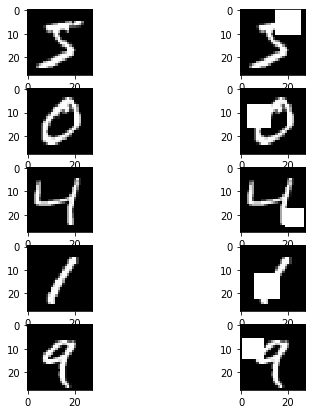

In [27]:
# autoenc
###Base setup taken from: https://github.com/baudm/ee298z to be able to run the benchmark code
###Base code modelled from: https://keras.io/examples/mnist_denoising_autoencoder/
import keras

from keras.models import Model

from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Dropout, BatchNormalization

from keras import backend as K

from keras import optimizers
from keras.optimizers import Adam, SGD
import numpy as np
import skimage
from hw2.transforms import corrupt_mnist_copy
from keras.datasets import mnist
from hw2.benchmark_keras import test_model
import matplotlib.pyplot as plt
from PIL import Image
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)
###End Code Chunk

# Scale to [0, 1]
x_train = x_train.astype('float32') / 255.
x_train_corrupted = x_train_corrupted.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_test_corrupted = x_test_corrupted.astype('float32') / 255.
plt.figure(num = 1, figsize = (7,7))
plt.title("Left-Original|Right-Corrupted")
for i in range(5):
    plt.subplot(5,2,(2*i)+1)
    plt.imshow(x_train[i],cmap = 'gray', vmin = 0, vmax = 1)
    plt.subplot(5,2,(2*i)+2)
    plt.imshow(x_train_corrupted[i],cmap = 'gray', vmin = 0, vmax = 1)
print("Left-Original|Right-Corrupted")

In [20]:
filters = 64
strides = 2
kernel_size = 3
activation = 'relu'
dropout = 0
latent_dim = 1000 #Arbitrary
#Based on https://keras.io/examples/mnist_denoising_autoencoder/

#Encoder
encoder_input = Input(shape = (28,28,1))
x = encoder_input
for i in range(2):
    x = Conv2D(filters = filters*(i+1),
                kernel_size = kernel_size,
                activation = activation,
                strides = strides,
                padding = "same")(x)
    x = BatchNormalization()(x)
pre_flatten_shape = K.int_shape(x)
x = Flatten()(x)
x_latent = Dense(latent_dim)(x)
encoder = Model(encoder_input, x_latent)

#Decoder
decoder_input = Input(shape = (latent_dim,))
x = decoder_input

#Get the preflattened shape
x = Dense(pre_flatten_shape[1]*pre_flatten_shape[2]*pre_flatten_shape[3])(decoder_input)
x = Reshape((pre_flatten_shape[1],pre_flatten_shape[2],pre_flatten_shape[3]))(x)
#reverse the Conv2D
for i in range(2):
    x = Conv2DTranspose(filters = filters*(i+1),
                kernel_size = kernel_size,
                activation = activation,
                strides = strides,
                padding = "same")(x)
    x = BatchNormalization()(x)

#Output a single image
x = Conv2DTranspose(filters = 1,
            kernel_size = kernel_size,
            strides = 1,
            #activation = activation why does adding this prevent training. Explore in the future
            padding = "same")(x)
decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

autoenc = Model(encoder_input, decoder(encoder(encoder_input)))
print("-------------------ENCODER----------------")
encoder.summary()
print("-------------------DECODER----------------")
decoder.summary()
print("-------------------AUTOENC----------------")
autoenc.summary()


-------------------ENCODER----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_25 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_15 (Dense)             (Non

In [28]:
#Reshape for inputting
x_train = np.reshape(x_train, [-1,28,28,1])
x_train_corrupted = np.reshape(x_train_corrupted, [-1,28,28,1])
x_test = np.reshape(x_test, [-1,28,28,1])
x_test_corrupted = np.reshape(x_test_corrupted, [-1,28,28,1])


adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, amsgrad=False)
autoenc.compile(loss = 'mean_squared_error',optimizer = adam)

autoenc.fit(x_train_corrupted, x_train,
            validation_data = (x_test_corrupted, x_test),
            epochs = 15,
            batch_size = 128,
            verbose = 0)


#Reload data because the reshaping seems to affect the use of "testmodel"
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.
test_model(autoenc, x_test, y_test, batch_size=100)
autoenc.save_weights('autoencmodel100epochs.h5')

print("Done Training")

Classifier score: 97.46
SSIM score: 97.69
Done Training


Left-Original|Middle-Corrupted|Right-Recovered


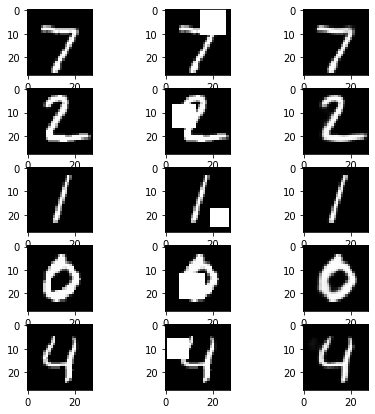

In [36]:
###Chunk
x_test = np.reshape(x_test, [-1,28,28,1])
x_test_corrupted = np.reshape(x_test_corrupted, [-1,28,28,1])

x_decoded = autoenc.predict(x_test_corrupted)
x_decoded = x_decoded.astype('float32')
x_test = np.reshape(x_test, [-1,28,28])
x_test_corrupted = np.reshape(x_test_corrupted, [-1,28,28])
x_decoded = np.reshape(x_decoded, [-1,28,28])
plt.figure(num = 2, figsize = (7,7))

print("Left-Original|Middle-Corrupted|Right-Recovered")
for i in range(5):
    
    plt.subplot(5,3,(i*3)+1)
    plt.imshow(x_test[i],cmap = 'gray', vmin = 0, vmax = 1)
    plt.subplot(5,3,(i*3)+2)
    plt.imshow(x_test_corrupted[i],cmap = 'gray', vmin = 0, vmax = 1)
    plt.subplot(5,3,(i*3)+3)
    plt.imshow(x_decoded[i],cmap = 'gray', vmin = 0, vmax = 1)


plt.show()

# Analysis

In [34]:
#By simply following the AutoEncoder Tutorial of keras, I was able to achieve the above benchmark score.
#The tutorial only used 16 latent dimentions. Increasing those latenet dimensions
#     improved the benchmark scores significantly. I settled at 1000 as 10000 took relatively too long to train

#Again 'relu' seemed to be the best activation function. I tried tanh and it did not outperform 'relu'
#     though i did not test this extensively

#Increasing the filters improved performance, at the cost of training time. I stopped at 64-128

#15 epochs seems to be around the sweet spot for this setup

#I increased the adam lr because it was taking a while to converge

#MSE was chosen as the loss function because this is not a categorical task.

#I did not bother experimenting with much deeper models because the input is only 28,28.
#     As it is this model has 7 layers and 12 million parameters already